# Introduction to Snorkel

In this first Snorkel tutorial, we will walk through the basics of Snorkel, using it to fight YouTube comments spam as our first example!

### Snorkel Basics

**Snorkel is a system for programmatically building and managing training datasets to rapidly and flexibly fuel machine learning models.**

Today's state-of-the-art machine learning models are more powerful and easy to use than ever before- however, they require massive _training datasets_.
For example, if we wanted to use one of the latest and greatest machine learning models to classify YouTube comments as spam or not, we'd need to first hand-label a large number of YouTube comments---a *training set*---that our model would learn from.

Building and managing training datasets often requires slow and prohibitively expensive manual effort by domain experts (especially when data is private or requires expensive expert labelers).
In Snorkel, users instead write **programmatic operations to label, transform, and structure training datasets** for machine learning, without needing to hand label any training data; Snorkel then uses novel, theoretically-grounded modeling techniques to clean and integrate the resulting training data.
In a wide range of applications---from medical image monitoring to text information extraction to industrial deployments over web data---Snorkel provides a radically faster and more flexible to build machine learning applications; see [snorkel.org](snorkel.org) for more detail on the many examples of Snorkel usage!

In this intro tutorial, we'll see how Snorkel can let us train a machine learning model for spam classification _without_ hand-labeling anything but a small test and validation set (i.e., without hand-labeling _any_ training data).

### The Snorkel Pipeline

<img src="img/snorkel_101_pipeline.png" align="left">`

Snorkel is a system for programmatically building and managing training datasets in a number of ways- we'll start with **labeling** training data.
Here, the basic pipeline consists of three main steps:

1. **Writing Labeling Functions:** First, instead of labeling the training data by hand, we will write _labeling functions_, special Python functions that label subsets of the training data heuristically.

2. **Combining & cleaning the labels:** The labeling functions we write will have varying accuracies, coverages, and correlations- leading to complex overlaps and disagreements. We will use Snorkel's `LabelModel` to automatically reweight and combine the outputs of the labeling functions, resulting in clean, _probabilistic_ training labels.

3. **Training a machine learning model:** Finally, we'll show how to use the probabilistic training labels from step (2) to train a machine learning model, which we'll show will generalize beyond and outperform the labeling functions!

For much more on Snorkel---including four years of academic papers, applications, and more!---see [snorkel.org](http://snorkel.org).
You can also check out the [Snorkel API documentation](https://snorkel.readthedocs.io/).

### Example Problem: Classifying YouTube Spam

<img src="img/snorkel_101_spam.png" width="500px" align="left">

For this tutorial, we'll focus on a [YouTube comments dataset](https://www.kaggle.com/goneee/youtube-spam-classifiedcomments) from Kaggle that consists of YouTube comments from 5 videos.
**For a much more detailed version of this tutorial, see the Snorkel [spam tutorial](https://github.com/snorkel-team/snorkel-tutorials/tree/master/spam).**

The simple classification task we focus on here is a classic one in the history of machine learning- classifying each comment as being "spam" or "ham" (not spam); more specifically, we aim to train a classifier that outputs one of the following labels for each YouTube comment:

* **`SPAM`**: irrelevant or inappropriate messages, or
* **`HAM`**: comments relevant to the video

For example, the following comments are `SPAM`:

        "Subscribe to me for free Android games, apps.."

        "Please check out my vidios"

        "Subscribe to me and I'll subscribe back!!!"

and these are `HAM`:

        "3:46 so cute!"

        "This looks so fun and it's a good song"

        "This is a weird video."
        
For our task, we have access to a large amount of *unlabeled YouTube comments*, which forms our **training set**.
We also have access to a small amount of labeled data, which we split into **development set** (for looking at while developing labeling functions), a **validation set** (for model hyperparameter tuning), and a **test set** (for final evaluation).
We load this data in now:

In [1]:
import os

# Make sure we're running from the spam/ directory
if os.path.basename(os.getcwd()) == "snorkel-tutorials":
    os.chdir("intro")

In [2]:
from utils import load_spam_dataset

# Load data- for details see the spam tutorial
df_train, df_dev, df_valid, df_test = load_spam_dataset()
Y_dev = df_dev["label"].values
Y_valid = df_valid["label"].values
Y_test = df_test["label"].values

Let's quickly look at a few data points, which have been loaded in as Pandas DataFrames:

In [3]:
import pandas as pd

# Don't truncate text fields in the display
pd.set_option("display.max_colwidth", 0)
df_dev.sample(5, random_state=3)

,author,date,text,label,video
128,Pepe The Meme King,2015-05-19T03:49:29.427000,everyday I&#39;m shufflin﻿,0,3
151,Melissa Erhart,NaN,Check out this playlist on YouTube:chcfcvzfzfbvzdr﻿,1,4
31,Angel,2014-11-02T17:27:09,"Hi there~I'm group leader of Angel, a rookie Korean pop group. We have four members, Chanicka, Julie, Stephanie, and myself, Leah. Please feel free to check out our channel and leave some feedback on our cover videos (: criticism is welcome as we know we're not top notch singers so please come leave some constructive feedback on our videos; we appreciate any chance to improve before auditioning for a Korean management company. We plan on auditioning for JYP, BigHit, Jellyfish, YG or SM. Thank you for taking time out of your day to read this !﻿",1,1
29,Sandeep Singh,2015-05-23T17:51:58.957000,Charlie from LOST﻿,0,4
237,BigBird Larry,2015-05-24T09:48:00.835000,Every single one of his songs brings me back to place I can never go back to and it hurts so bad inside﻿,0,4


Each row is one comment consisting of text, author, and date values, as well as an integer id for which YouTube video the comment corresponds to.
Additionally, since we are looking at the development set, these examples have labels as well- `1` for spam, `0` for ham (not spam).

## STEP 1: Writing Labeling Functions

_Labeling functions (LFs)_ are one of the core operators for building and managing training datasets programmatically in Snorkel.
The basic idea is simple: **a labeling function is a function that labels some subset of the training dataset**.
That is, each labeling function either outputs `SPAM`, `HAM`, or `ABSTAIN`:

In [4]:
HAM = 0
SPAM = 1
ABSTAIN = -1

Labeling functions can be used to represent many heuristic strategies for labeling data.
**The key idea is that labeling functions do not need to be perfectly accurate**, as Snorkel will automatically estimate their accuracies and correlations, and then reweight and combine their output labels, leading to high-quality training labels.

As a starting example, labeling functions can be based on heuristically **matching keywords**:

In [5]:
from snorkel.labeling.lf import labeling_function

@labeling_function()
def lf_keyword_my(x):
    """Many spam comments talk about 'my channel', 'my video', etc."""
    return SPAM if "my" in x.text.lower() else ABSTAIN

Labeling functions can also use **regular expressions**:

In [6]:
import re

@labeling_function()
def lf_regex_check_out(x):
    """Spam comments say 'check out my video', 'check it out', etc."""
    return SPAM if re.search(r"check.*out", x.text, flags=re.I) else ABSTAIN

Labeling functions can of course flexibly express a range of other **heuristics**:

In [7]:
@labeling_function()
def lf_short_comment(x):
    """Ham comments are often short, such as 'cool video!'"""
    return HAM if len(x.text.split()) < 5 else ABSTAIN

Labeling functions can also use **third-party models**:

In [8]:
from textblob import TextBlob

@labeling_function()
def lf_textblob_polarity(x):
    """
    We use a third-party sentiment classification model, TextBlob,
    combined with the heuristic that ham comments are often positive.
    """
    sentiment = TextBlob(x.text).sentiment
    return HAM if sentiment.polarity > 0.3 else ABSTAIN

For many more types of labeling functions---including over data modalities beyond text---see the other [tutorials](https://github.com/snorkel-team/snorkel-tutorials) and examples at [snorkel.org](http://snorkel.org).
In general the process of developing labeling functions is, like any other development process, an iterative one that takes time- but that, in [many cases](http://snorkel.org), can be orders-of-magnitude faster that hand-labeling training data.
For more detail on the process of developing labeling functions and other training data operators in Snorkel, see the [full version of this tutorial](https://github.com/snorkel-team/snorkel-tutorials/tree/master/spam).

For now, we proceed by loading the above labeling functions plus some additional similar ones from a utility file:

In [9]:
from lfs import lfs

## STEP 2: Combining & Cleaning the Labels

Our next step is to apply the labeling functions we wrote to the unlabeled training data; we do this using the `LFApplier` corresponding to our base data class (in this case, the `PandasLFApplier`):

In [10]:
from snorkel.labeling.apply import PandasLFApplier

applier = PandasLFApplier(lfs)
L_train = applier.apply(df_train)
L_dev = applier.apply(df_dev)
L_test = applier.apply(df_test)

100%|██████████| 250/250 [00:00<00:00, 1064.04it/s]


The result of applying the labeling functions (LFs) to the data is (for each split of the data) a sparse _label matrix_ with rows corresponding to data points, and columns corresponding to LFs.
We can take a look at some statistics of the LFs on the dev set:

In [11]:
from snorkel.labeling.analysis import LFAnalysis
LFAnalysis(L_dev, lfs).lf_summary(Y=Y_dev)

,j,Polarity,Coverage,Overlaps,Conflicts,Correct,Incorrect,Emp. Acc.
lf_keyword_my,0,[1],0.22,0.21,0.13,19,3,0.863636
lf_subscribe,1,[1],0.08,0.05,0.02,8,0,1.000000
lf_link,2,[1],0.10,0.07,0.05,10,0,1.000000
lf_please,3,[1],0.10,0.09,0.05,10,0,1.000000
lf_song,4,[0],0.16,0.11,0.06,11,5,0.687500
lf_regex_check_out,5,[1],0.29,0.18,0.10,29,0,1.000000
lf_short_comment,6,[0],0.28,0.13,0.05,19,9,0.678571
lf_textblob_polarity,7,[0],0.28,0.23,0.11,18,10,0.642857
lf_textblob_subjectivity,8,[0],0.08,0.08,0.04,5,3,0.625000


Above, we see that the LFs indeed have varying accuracies, conflict with each other on non-negligible portions of the training set, and also each only cover some subset of the training set.
Next, we use Snorkel's `LabelModel` to automatically learn the accuracies* and correlations of the LFs, and reweight and combine their outputs into a final set of _probabilistic_ training labels.

*_Note that the "Empirical Accuracies" in the table above are computed over a very small labeled development set that we looked at while writing the LFs- thus, it is a very biased estimate of their accuracies (this is, for example, why so many of them have 100% accuracy according to this estimate...).  Thus, we rely on a [novel unsupervised generative modeling technique](https://arxiv.org/abs/1605.07723) in Snorkel to learn their accuracies in a provably convergent way over the much larger unlabeled training set. For more technical details of this overall approach, see our [NeurIPS 2016](https://arxiv.org/abs/1605.07723) and [AAAI 2019](https://arxiv.org/abs/1810.02840) papers._

In [12]:
from snorkel.labeling.model import LabelModel

# Training the LabelModel
label_model = LabelModel(cardinality=2, verbose=True)
label_model.fit(L_train, n_epochs=500, log_freq=50, seed=123)

# Getting the probabilistic labels for the training set from the LabelModel
Y_probs_train = label_model.predict_proba(L=L_train)

# Computing the accuracy of the LabelModel
label_model_acc = label_model.score(L_test, Y_test)["accuracy"]
print(f"{'Label Model Accuracy:':<25} {label_model_acc * 100:.1f}%")

Computing O...
Estimating \mu...
[0 epochs]: TRAIN:[loss=0.127]
[50 epochs]: TRAIN:[loss=0.012]
[100 epochs]: TRAIN:[loss=0.010]
[150 epochs]: TRAIN:[loss=0.009]
[200 epochs]: TRAIN:[loss=0.008]
[250 epochs]: TRAIN:[loss=0.008]
[300 epochs]: TRAIN:[loss=0.008]
[350 epochs]: TRAIN:[loss=0.008]
[400 epochs]: TRAIN:[loss=0.008]
[450 epochs]: TRAIN:[loss=0.008]
Finished Training
Label Model Accuracy:     84.8%


Note that above, we have applied the `LabelModel` to the test set, and see that we get an accuracy score of approximately $85\%$.
In many Snorkel applications, it is not possible to apply the labeling functions (and therefore the `LabelModel`) at test time, for example due to the labeling functions using features not available at test time, or being overly slow to execute (for an example of this, see the [cross-modal tutorial](), and other examples at [snorkel.org]()).

Here, we _can_ apply the `LabelModel` to the test set, but it leaves a lot to be desired- in part because the labeling functions leave a large portion of the dataset unlabeled:

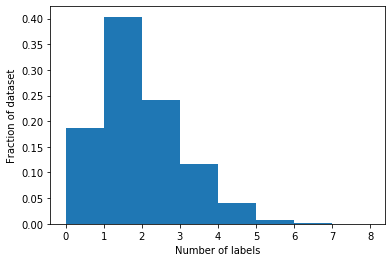

In [13]:
from utils import plot_label_frequency
plot_label_frequency(L_train)

However, where is where the final step of the pipeline comes in handy- we will now use the probabilistic training labels to train a machine learning model which will generalize beyond---and outperform---the labeling functions.

## STEP 3: Training a Machine Learning Model

In this final step, our goal is to train a machine learning model that generalizes beyond what the labeling functions label, and thereby outperforms the `LabelModel` above.
In this example, **we use an extremely simple ML model**, but still see this generalization effect occur!

Note that because the output of the Snorkel `LabelModel` is just a set of labels, Snorkel easily integrates with most popular libraries for performing supervised learning: TensorFlow, Keras, PyTorch, Scikit-Learn, Ludwig, XGBoost, etc.

In this tutorial we demonstrate using classifiers from Keras and Scikit-Learn. For simplicity and speed, we use a simple "bag of n-grams" feature representation: each data point is represented by a one-hot vector marking which words or 2-word combinations are present in the comment text, which we compute using a basic Scikit-Learn `CountVectorizer`:

In [14]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(ngram_range=(1, 2))
X_train = vectorizer.fit_transform([row.text for i, row in df_train.iterrows()])
X_valid = vectorizer.transform([row.text for i, row in df_valid.iterrows()])
X_test = vectorizer.transform([row.text for i, row in df_test.iterrows()])

**TODO: This step will be removed!**

In [15]:
mask = L_train.sum(axis=1) != ABSTAIN * len(lfs)
X_train = X_train[mask, :]
Y_probs_train = Y_probs_train[mask]

Now, we'll use Keras, a popular high-level API for building models in TensorFlow, to build a simple logistic regression classifier.
We compile it with a `categorical_crossentropy` loss so that it can handle probabilistic labels instead of integer labels.
Using a _noise-aware loss_ &mdash; one that uses probabilistic labels &mdash; for our discriminative model lets
us take full advantage of the label model's learning procedure (see our [NeurIPS 2016 paper](https://arxiv.org/abs/1605.07723)).
We use the common settings of an `Adam` optimizer and early stopping (evaluating the model on the validation set after each epoch and reloading the weights from when it achieved the best score).
For more information on Keras, see the [Keras documentation](https://keras.io/).

In [16]:
from snorkel.analysis.utils import probs_to_preds, preds_to_probs
from snorkel.analysis.metrics import metric_score
import tensorflow as tf

# Our model is a simple linear layer mapping from feature
# vectors to the number of labels in our problem (2).
keras_model = tf.keras.Sequential()
keras_model.add(
    tf.keras.layers.Dense(
        2,
        input_dim=X_train.shape[1],
        activation=tf.nn.softmax,
        kernel_regularizer=tf.keras.regularizers.l2(0.01),
    )
)
optimizer = tf.keras.optimizers.Adam(lr=0.001)
keras_model.compile(
    optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_acc", patience=10, verbose=1, restore_best_weights=True
)

keras_model.fit(
    X_train,
    Y_probs_train,
    validation_data=(X_valid, preds_to_probs(Y_valid, 2)),
    callbacks=[early_stopping],
    epochs=20,
    verbose=0,
)

Y_preds_test = probs_to_preds(keras_model.predict(X_test))
print(f"Test Accuracy: {metric_score(Y_test, Y_preds_test, metric='accuracy')}")

/Users/ajratner/repos/snorkel-tutorials/.env_intro/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/ajratner/repos/snorkel-tutorials/.env_intro/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/ajratner/repos/snorkel-tutorials/.env_intro/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)]

Restoring model weights from the end of the best epoch.
Epoch 00020: early stopping
Test Accuracy: 0.924


**We observe an additional boost in accuracy over the `LabelModel` by multiple points!
By using the label model to transfer the domain knowledge encoded in our LFs to the discriminative model,
we were able to generalize beyond the noisy labeling heuristics**.

### Next Steps

In this tutorial, we demonstrated the basic pipeline of Snorkel, and showed how it can enable us to train high-quality ML models without hand-labeling large training datasets.

**Next, check out the extended version of this tutorial---the [spam tutorial](https://github.com/snorkel-team/snorkel-tutorials/tree/master/spam)---which goes into much more detail about the actual process of iterating on labeling functions and other types of operators to build end-to-end ML applications in Snorkel!**

You can also check out the [Snorkel 101 Guide](#) and the [`snorkel-tutorials` table of contents](https://github.com/snorkel-team/snorkel-tutorials#snorkel-tutorials) for other tutorials that you may find interesting, including demonstrations of how to use Snorkel:

* As part of a [hybrid crowdsourcing pipeline](https://github.com/snorkel-team/snorkel-tutorials/tree/master/crowdsourcing)
* For [scene-graph detection over images](https://github.com/snorkel-team/snorkel-tutorials/tree/master/scene_graph)
* For [information extraction over text](https://github.com/snorkel-team/snorkel-tutorials/tree/master/spouse)
* For [data augmentation](https://github.com/snorkel-team/snorkel-tutorials/tree/master/spam)

and many more!
You can also visit the [Snorkel homepage](http://snorkel.org) or [Snorkel API documentation](https://snorkel.readthedocs.io) for more info!